In [1]:
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")
import os

physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    for gpu in physical_devices:
        tf.config.experimental.set_memory_growth(gpu,True)

2024-11-02 08:31:35.525207: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-02 08:31:35.544206: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-02 08:31:35.552042: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-02 08:31:35.575858: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
I0000 00:00:1730536300.036604    1494 cuda_executor.c

In [2]:
import polars as pl
import numpy as np
import os
directory = '/app/finalDataSets'
# directory = r'D:\github\localt20'

playerStats = tf.convert_to_tensor(np.load(os.path.join(directory,'playerStats.npy')))
balltoball = tf.convert_to_tensor(pl.read_csv(os.path.join(directory,'balltoball.csv')))
teamStats = tf.convert_to_tensor(pl.read_csv(os.path.join(directory,'team12Stats.csv')))

# Shapes of the data
playerStats_shape = playerStats.shape
teamStats_shape = teamStats.shape
balltoball_shape = balltoball.shape
playerStats_shape,teamStats_shape,balltoball_shape

I0000 00:00:1730536302.877860    1494 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730536302.877963    1494 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730536302.878004    1494 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730536303.087773    1494 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730536303.087885    1494 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-02

(TensorShape([1156, 22, 23]),
 TensorShape([1156, 24]),
 TensorShape([267455, 6]))

In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNet

# Define CNN Model for player stats
def create_cnn_model():
    cnn_input = layers.Input(shape=(22, 23, 1), name="player_stats_input")
    x = layers.Resizing(32, 32)(cnn_input)   # Resize to MobileNet input size
    x = layers.Conv2D(3, (1, 1), activation='relu')(x)  # Convert 1 channel to 3 channels
    x = MobileNet(include_top=False, weights=None, input_shape=(32, 32, 3))(x)
    x = layers.GlobalAveragePooling2D()(x)  # Flatten to fixed-size vector
    x = layers.Dense(50, activation='relu')(x)  # Compress to 50 features (optional)
    return models.Model(inputs=cnn_input, outputs=x, name="CNN_Model")

# Define DNN Model for team stats
def create_dnn_model():
    dnn_input = layers.Input(shape=(24,), name="team_stats_input")
    y = layers.Dense(5, activation='relu')(dnn_input)  # Compress to 5 features
    return models.Model(inputs=dnn_input, outputs=y, name="DNN_Model")

# Define RNN Model for ball-by-ball data
def create_rnn_model(input_shape):
    rnn_input = layers.Input(shape=input_shape, name="balltoball_input")
    z = layers.Masking(mask_value=0)(rnn_input)
    z = layers.LSTM(64, return_sequences=True)(z)
    z = layers.LSTM(32)(z)
    z = layers.Dense(32, activation='relu')(z)
    return models.Model(inputs=rnn_input, outputs=z, name="RNN_Model")

# Instantiate models
cnn_model = create_cnn_model()
dnn_model = create_dnn_model()
rnn_model = create_rnn_model((None, balltoball_shape[1]))  # Variable sequence length

# Combine models
combined_input = layers.Concatenate()([
    cnn_model.output,  # Output of CNN for player stats
    dnn_model.output,  # Output of DNN for team stats
    rnn_model.output   # Output of RNN for ball-by-ball data
])

# Final DNN for classification
x = layers.Dense(64, activation='relu')(combined_input)
x = layers.Dense(32, activation='relu')(x)
final_output = layers.Dense(1, activation='sigmoid', name="final_output")(x)  # Binary classification

# Define the full model
full_model = models.Model(
    inputs=[cnn_model.input, dnn_model.input, rnn_model.input],
    outputs=final_output,
    name="Combined_Model"
)

# Compile the model
full_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model summary
full_model.summary()

Model: "Combined_Model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ player_stats_input  │ (None, 22, 23, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ balltoball_input    │ (None, None, 6)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resizing (Resizing) │ (None, 32, 32, 1) │          0 │ player_stats_inp… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, None, 6)   │          0 │ balltoball_input… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32, 3) │          6 │ resizing[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking (Masking)   │ (None, None, 6)   │          0 │ balltoball_input… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any (Any)           │ (None, None)      │          0 │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mobilenet_1.00_32   │ (None, 1, 1,      │  3,228,864 │ conv2d[0][0]      │
│ (Functional)        │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, None, 64)  │     18,176 │ masking[0][0],    │
│                     │                   │            │ any[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1024)      │          0 │ mobilenet_1.00_3… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ team_stats_input    │ (None, 24)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 32)        │     12,416 │ lstm[0][0],       │
│                     │                   │            │ any[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 50)        │     51,250 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 5)         │        125 │ team_stats_input… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │      1,056 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 87)        │          0 │ dense[0][0],      │
│ (Concatenate)       │                   │            │ dense_1[0][0],    │
│                     │                   │            │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │      5,632 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 32)        │      2,080 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ final_output        │ (None, 1)         │         33 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 3,319,638 (12.66 MB)

 Trainable params: 3,297,750 (12.58 MB)

 Non-trainable params: 21,888 (85.50 KB)

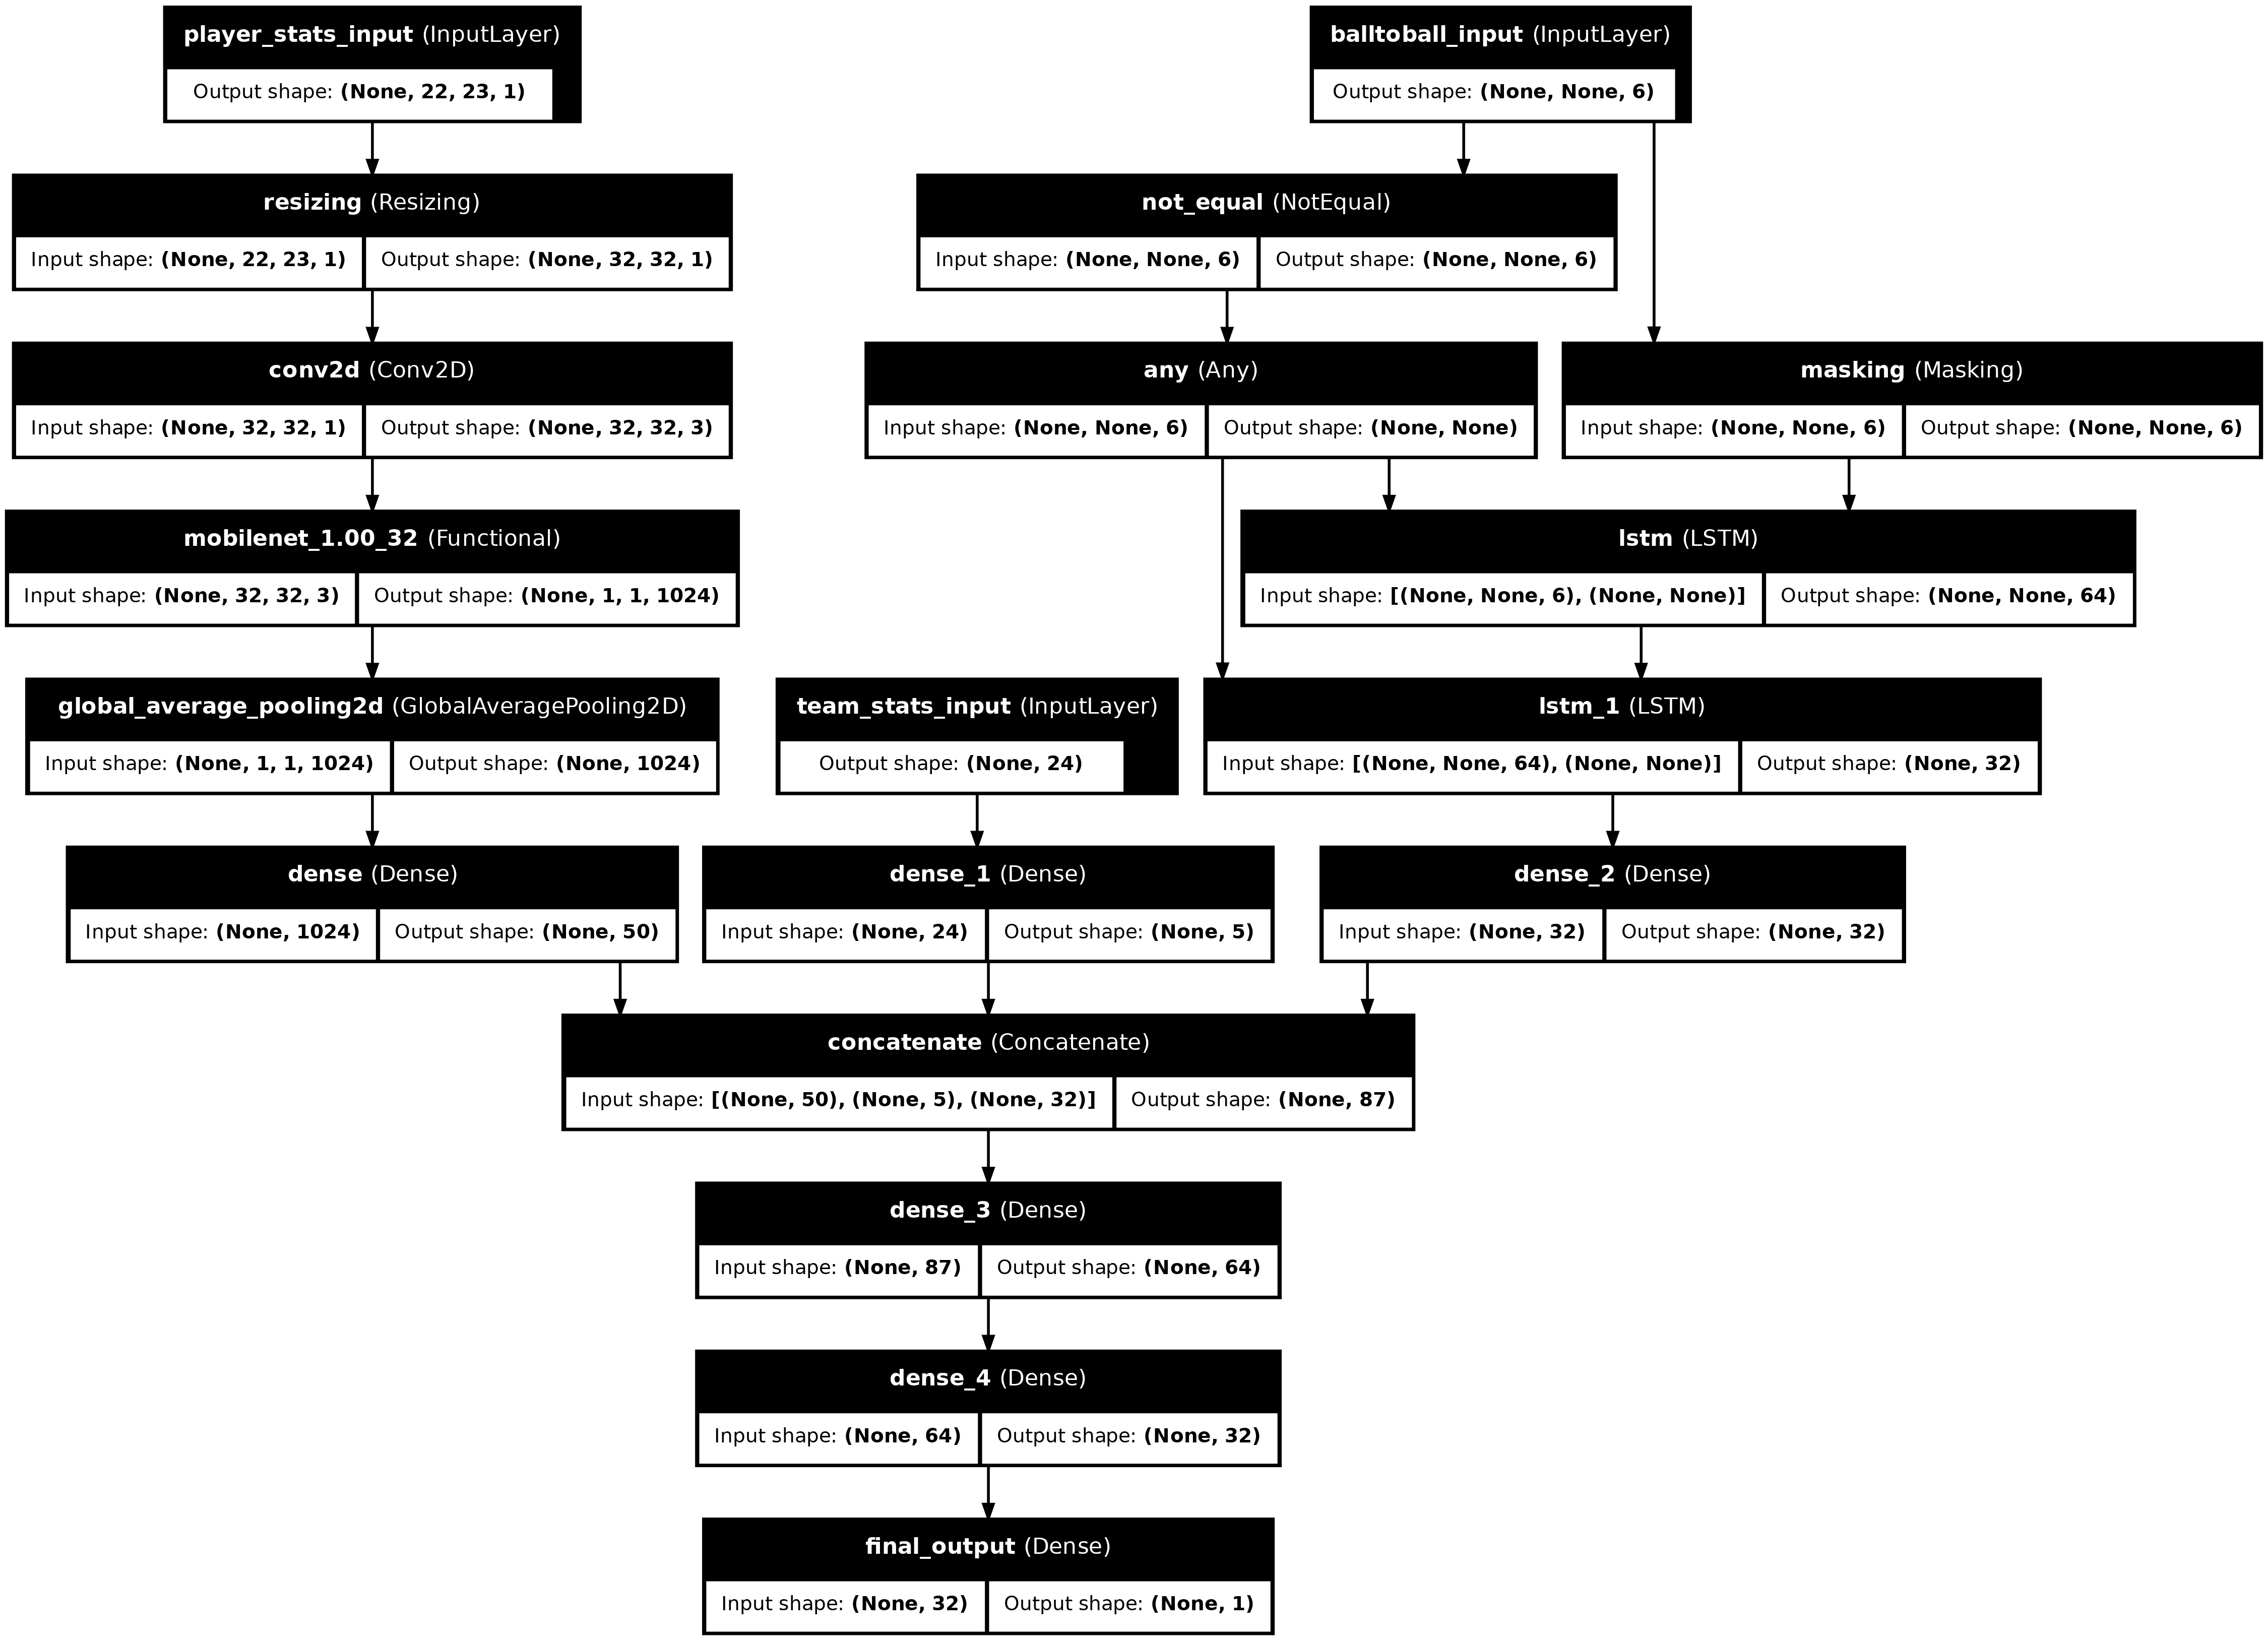

In [4]:
from tensorflow.keras.utils import plot_model

# Save model graph to a file
plot_model(full_model, to_file='combined_model_graph.png', show_shapes=True, show_layer_names=True)